# Import necessary modules

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold

# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Prepare Data

In [2]:
df = pd.read_csv("clean_compiled_transcripts.csv", index_col = "Participant_ID")
df.head()

,Transcript,PHQ_Binary
Participant_ID,,
300,good atlanta georgia um my parents um i love i...,0
301,thank you mmm k i good thank you i los angeles...,0
302,i fine yourself i los angeles california part ...,0
303,okay bout yourself california yeah oh well it ...,0
304,i good um los angeles california um cool weath...,0


## Convert transcripts to occurrence matrix (skip if you have the numpy X data)

In [3]:
CV = CountVectorizer(min_df=3) # ignore terms that appear in less than 3 documents

X = CV.fit_transform(df.Transcript).toarray()

np.save("bow_features.npy", X)

## Split the dataset 

In [4]:
X = np.load("bow_features.npy")
y = df.PHQ_Binary

In [5]:
def get_ylabel(val):
    # due to upsampling in train dataset, there are many repeated participants e.g. 305
    if isinstance(val, np.int64):
        return val
    else:
        return val.values[0] # the other values are the same

def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        yi_label = get_ylabel(y[participant_no])
        
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(yi_label)
        else:
            X_train.append(X[i])
            y_train.append(yi_label)
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test(X, y)

In [6]:
RANDOM_STATE = 42

# shuffle the train data in unison because I have arranged them in order when loaded (labels 0 followed by 1)
# reduces poor performance during k-cross validation when sampling data
X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 4939), (45, 4939), (240,), (45,))

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [7]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [8]:
def k_cross(model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [9]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Gaussian Naive Bayes 

In [10]:
nb_model = GaussianNB()

f1_scores, recall_scores = k_cross(nb_model)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

f1 mean score: 0.93984610458705
recall mean score: 0.9666666666666666


[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5034562211981567
              precision    recall  f1-score   support

           0       0.69      0.94      0.79        31
           1       0.33      0.07      0.12        14

    accuracy                           0.67        45
   macro avg       0.51      0.50      0.46        45
weighted avg       0.58      0.67      0.58        45

Confusion Matrix: 
 [[29  2]
 [13  1]]


GaussianNB()

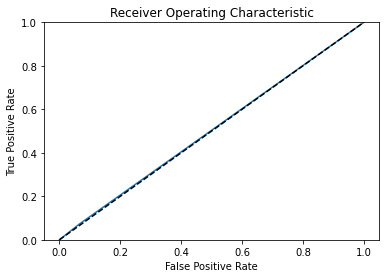

In [11]:
evaluate_model(nb_model)

## Logistic Regression 

In [12]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.8056379419785875 > best f1 = -1
power: 0: recall = 0.8165112665112664 > best recall = -1
power: 1: f1 = 0.8073770724133702 > best f1 = 0.8056379419785875
power: 1: recall = 0.824203574203574 > best recall = 0.8165112665112664
power: 6: f1 = 0.8111807995131978 > best f1 = 0.8073770724133702


[0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0
 1 0 0 0 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.6566820276497696
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        31
           1       0.50      0.57      0.53        14

    accuracy                           0.69        45
   macro avg       0.65      0.66      0.65        45
weighted avg       0.70      0.69      0.69        45

Confusion Matrix: 
 [[23  8]
 [ 6  8]]


LogisticRegression(C=1000000, n_jobs=3)

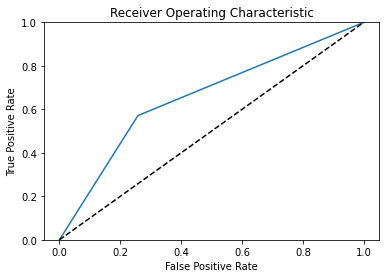

In [13]:
# Based on f1
evaluate_model(best_logreg_f1_model)

[0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0
 1 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.6336405529953918
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.55      0.43      0.48        14

    accuracy                           0.71        45
   macro avg       0.66      0.63      0.64        45
weighted avg       0.70      0.71      0.70        45

Confusion Matrix: 
 [[26  5]
 [ 8  6]]


LogisticRegression(C=10, n_jobs=3)

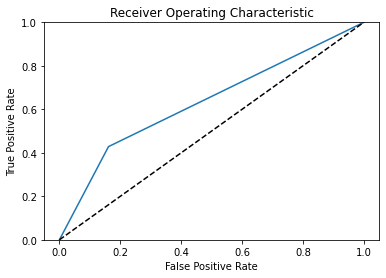

In [14]:
# Based on recall
evaluate_model(best_logreg_recall_model)

## Decision Tree

In [15]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.6834809734170348 > best f1 = -1
depth: 1, leaf: 1: recall = 0.6360800310800311 > best recall = -1
depth: 2, leaf: 1: recall = 0.6793278943278944 > best recall = 0.6360800310800311
depth: 2, leaf: 6: f1 = 0.6844272828620653 > best f1 = 0.6834809734170348
depth: 2, leaf: 18: f1 = 0.6939490254872563 > best f1 = 0.6844272828620653
depth: 2, leaf: 18: recall = 0.6997319347319348 > best recall = 0.6793278943278944
depth: 2, leaf: 23: f1 = 0.7022541602501915 > best f1 = 0.6939490254872563
depth: 2, leaf: 23: recall = 0.7151359751359753 > best recall = 0.6997319347319348
depth: 3, leaf: 23: f1 = 0.7025900511282819 > best f1 = 0.7022541602501915
depth: 3, leaf: 24: f1 = 0.7050248337369776 > best f1 = 0.7025900511282819
depth: 3, leaf: 24: recall = 0.719933954933955 > best recall = 0.7151359751359753
depth: 3, leaf: 25: recall = 0.729024864024864 > best recall = 0.719933954933955
depth: 3, leaf: 27: f1 = 0.7065855918194748 > best f1 = 0.7050248337369776
depth: 3, leaf: 

[0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1
 1 0 0 1 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5564516129032259
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        31
           1       0.37      0.50      0.42        14

    accuracy                           0.58        45
   macro avg       0.55      0.56      0.55        45
weighted avg       0.62      0.58      0.59        45

Confusion Matrix: 
 [[19 12]
 [ 7  7]]


DecisionTreeClassifier(max_depth=4, min_samples_leaf=24, random_state=42)

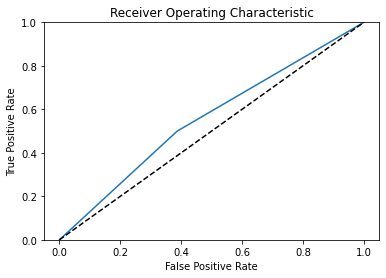

In [16]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5817972350230415
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        31
           1       0.45      0.36      0.40        14

    accuracy                           0.67        45
   macro avg       0.59      0.58      0.58        45
weighted avg       0.65      0.67      0.65        45

Confusion Matrix: 
 [[25  6]
 [ 9  5]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=27, random_state=42)

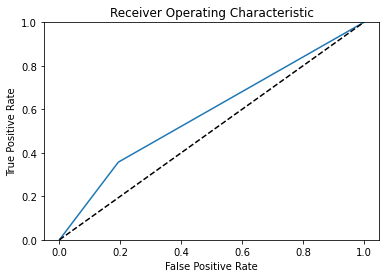

In [17]:
# Based on recall
evaluate_model(best_tree_recall_model)

## Random Forest

In [18]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.6087670011148273 > best f1 = -1
estimator: 1: recall = 0.6184071484071485 > best recall = -1
estimator: 3: f1 = 0.6816568180760558 > best f1 = 0.6087670011148273
estimator: 3: recall = 0.6978282828282827 > best recall = 0.6184071484071485
estimator: 5: f1 = 0.7311671737873111 > best f1 = 0.6816568180760558
estimator: 5: recall = 0.7511266511266511 > best recall = 0.6978282828282827
estimator: 7: f1 = 0.7353748296791776 > best f1 = 0.7311671737873111
estimator: 7: recall = 0.7521522921522921 > best recall = 0.7511266511266511
estimator: 9: f1 = 0.7700055741360089 > best f1 = 0.7353748296791776
estimator: 9: recall = 0.7833799533799534 > best recall = 0.7521522921522921
estimator: 17: f1 = 0.7806074914003303 > best f1 = 0.7700055741360089
estimator: 21: f1 = 0.7969341792052789 > best f1 = 0.7806074914003303


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5195852534562212
              precision    recall  f1-score   support

           0       0.70      0.97      0.81        31
           1       0.50      0.07      0.12        14

    accuracy                           0.69        45
   macro avg       0.60      0.52      0.47        45
weighted avg       0.64      0.69      0.60        45

Confusion Matrix: 
 [[30  1]
 [13  1]]


RandomForestClassifier(n_estimators=21, random_state=42)

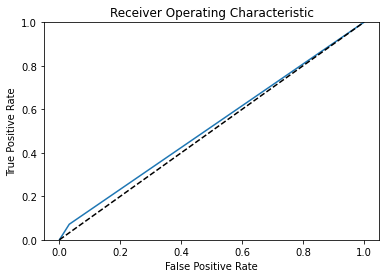

In [19]:
# Based on f1
evaluate_model(best_forest_f1_model)

[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5426267281105991
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        31
           1       0.43      0.21      0.29        14

    accuracy                           0.67        45
   macro avg       0.57      0.54      0.53        45
weighted avg       0.62      0.67      0.63        45

Confusion Matrix: 
 [[27  4]
 [11  3]]


RandomForestClassifier(n_estimators=9, random_state=42)

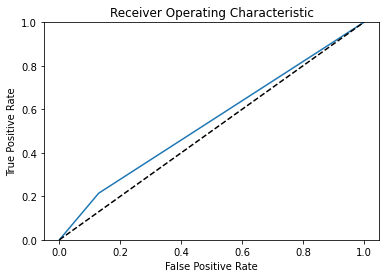

In [20]:
# Based on recall
evaluate_model(best_forest_recall_model)

## SVM with grid search

In [21]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   26.4s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.9s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   26.1s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.6s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.8s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.9s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   26.0s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.7s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.9s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   25.6s finished


f1 mean score: 0.7826157635467981
recall mean score: 0.7795571095571096


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   32.0s finished


[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
AUC is:  0.5622119815668203
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        31
           1       0.44      0.29      0.35        14

    accuracy                           0.67        45
   macro avg       0.58      0.56      0.56        45
weighted avg       0.64      0.67      0.64        45

Confusion Matrix: 
 [[26  5]
 [10  4]]
Best SVM parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


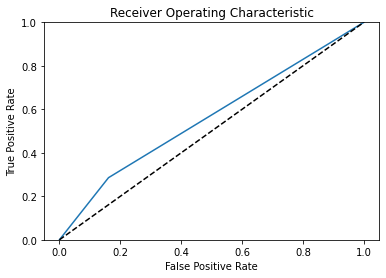

In [22]:
best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")